# Pendulum

In [1]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
from parallelEnv import parallelEnv
import numpy as np
import gym
import time
%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


## Environment

In [2]:
nb_agent=4
envs = parallelEnv('Pendulum-v0', n=nb_agent)
envs.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([[ 0.59933422,  0.8004989 , -0.92015067],
       [ 0.31865112, -0.94787207, -0.16649821],
       [ 0.58045822,  0.81429003,  0.66931333],
       [-0.9734302 ,  0.22898396, -0.2521836 ]])

/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tens

## Policy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class Policy(nn.Module):
    def __init__(self, state_size, action_size, fc1_units,fc11_units, std=0.0):
        super(Policy, self).__init__()
        self.fc1  = nn.Linear(state_size, fc1_units)
        self.fc11 = nn.Linear(fc1_units, fc11_units)
        self.fc2v = nn.Linear(fc11_units, 1)
        self.fc2a = nn.Linear(fc11_units, action_size)
        self.reset_parameters()
        self.log_std = nn.Parameter(torch.ones(1, action_size) * std)   
   

    def reset_parameters(self):
        self.fc1.weight.data.normal_(mean=0., std=0.1)
        self.fc11.weight.data.normal_(mean=0., std=0.1)
        self.fc2a.weight.data.normal_(mean=0., std=0.1)
        self.fc2v.weight.data.normal_(mean=0., std=0.1)
       
    def forward(self, state):
 
        value = F.relu(self.fc1(state))
        value = F.relu(self.fc11(value))
        value = self.fc2v(value)

        mu = F.relu(self.fc1(state))
        mu = F.relu(self.fc11(mu))
        mu = self.fc2a(mu)


        std   = self.log_std.exp().expand_as(mu)
        distribution  = Normal(mu, std)
        return distribution, value
    
 
# run your own policy!
# policy=Policy().to(device)
policy=Policy(state_size=3, action_size=1,fc1_units=128,fc11_units=64).to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

## Function Definitions

In [4]:
def collect_trajectories(envs, policy, tmax=200, nrand=5):
        
    n=len(envs.ps)
    #initialize returning lists and start the game!
    state_list =[]
    reward_list=[]
    prob_list  =[]
    action_list=[]
    value_list =[]
    log_probs_list=[]

    envs.reset()
    
    #start all parallel agents

#    envs.step([[1]]*n)
    
    # perform nrand random steps
    for i in range(nrand):
        action = [[np.random.uniform(-2, 2)] for _ in range(n)]
        next_states, rewards, dones, _ = envs.step(action)

    
    log_probs=[]
    values   =[]
    actions  =[]
    values_list = []
    for t in range(tmax):
        state_list.append(next_states)
        values=[]
        for state in next_states:
 
            state=torch.tensor([state], dtype=torch.float, device=device)
            distribution, value = policy(state)
            action = distribution.sample()
            log_prob = distribution.log_prob(action).detach()
            actions.append(action.squeeze())
            values.append(value.squeeze().data)
            log_probs.append(log_prob.squeeze()) 

        next_states, rewards, is_dones,_= envs.step(actions)
        reward_list.append(rewards)
        values_list.append(values) 
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_dones.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return log_probs , state_list,actions, reward_list,values_list

In [5]:
old_probs, states, actions, rewards, values = collect_trajectories(envs, policy, tmax=4,nrand=2)
print("actions",actions)
print()
print("probs",old_probs)
print()
print("values",values)
print()
print("rewards",rewards)
 

actions [tensor(-0.0500), tensor(0.2201), tensor(0.8879), tensor(0.0301), tensor(-1.6519), tensor(-0.2028), tensor(0.3008), tensor(0.2238), tensor(0.5538), tensor(-0.2573), tensor(-0.3848), tensor(-0.4150), tensor(2.6173), tensor(-0.5261), tensor(0.0177), tensor(0.3366)]

probs [tensor(-0.9305), tensor(-0.9701), tensor(-1.5019), tensor(-0.9328), tensor(-1.9239), tensor(-0.9269), tensor(-1.0527), tensor(-0.9854), tensor(-1.2478), tensor(-0.9430), tensor(-0.9295), tensor(-0.9555), tensor(-5.0940), tensor(-1.0575), tensor(-0.9554), tensor(-1.0366)]

values [[tensor(-0.0016), tensor(-0.0816), tensor(0.0017), tensor(-0.0028)], [tensor(0.0113), tensor(-0.0602), tensor(0.0122), tensor(-0.0018)], [tensor(0.0208), tensor(-0.0317), tensor(0.0262), tensor(-0.0019)], [tensor(0.0227), tensor(0.0013), tensor(0.0280), tensor(-0.0009)]]

rewards [array([-3.41942674, -4.33971393, -4.00205883, -8.39331981]), array([-4.02276022, -5.07357627, -4.50753598, -8.39048782]), array([-4.88761491, -6.05926535, -5

In [6]:
discount=0.99
discount = discount**np.arange(len(rewards))
rewards = np.asarray(rewards)*discount[:,np.newaxis]
rewards_future = rewards[::-1].cumsum(axis=0)[::-1]

print(rewards_future)
print(rewards)
print(rewards-values)

[[-18.026347   -22.36165356 -19.42041684 -33.27931165]
 [-14.60692026 -18.02193963 -15.41835801 -24.88599184]
 [-10.62438764 -12.99909913 -10.95589739 -16.5794089 ]
 [ -5.83403626  -7.06041316  -5.86702765  -8.30206576]]
[[-3.41942674 -4.33971393 -4.00205883 -8.39331981]
 [-3.98253262 -5.0228405  -4.46246062 -8.30658294]
 [-4.79035138 -5.93868597 -5.08886974 -8.27734314]
 [-5.83403626 -7.06041316 -5.86702765 -8.30206576]]
[[-3.41782649 -4.25810785 -4.00373102 -8.39051533]
 [-3.99380054 -4.96262966 -4.47463528 -8.30475727]
 [-4.81114483 -5.90701456 -5.11506122 -8.27541189]
 [-5.85672243 -7.06173785 -5.89506929 -8.30115299]]


## Clipped surrogate
In PPO algorithm the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [7]:
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def clipped_surrogate(policy, old_log_probs, states, actions, rewards,values,discount=0.995,epsilon=0.1, beta=0.01):
    actions=[]
    new_log_probs=[]
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]-values
    # print("rewards F:",rewards)
    # print("values ",values)
    # normalize the reward: (x-mean)/std 
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    # convert states to policy (or probability)
    # evaluate the new prob: this is what we have:(s,a,r,s') for old prob. 
    new_log_probs=[]
    entropies=[]
 
    for state in states:
        for s in state:
            s=torch.tensor([s], dtype=torch.float, device=device)
            distribution, value = policy(s)   
            action = distribution.sample()
            log_prob = distribution.log_prob(action)
            entropy =distribution.entropy()
            new_log_probs.append(log_prob)
            entropies.append(entropy)
    new_log_probs=torch.stack(new_log_probs)
    old_log_probs=torch.stack(old_log_probs)
    entropies=torch.stack(entropies)

    # ratio for clipping
    ratio=(new_log_probs-old_log_probs).exp()

    # clipped function
    clip = torch.clamp(ratio,min= 1-epsilon,max= 1+epsilon)
    rewards=rewards.view(1,-1).squeeze()
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    #    print("old_log_probs ",new_log_probs.exp())
#    print("new_log_probs",new_log_probs.exp())
#    entropy = -(new_log_probs.exp()*old_log_probs)+(1.0-new_log_probs.exp())*torch.log(1.0-old_log_probs.exp()+1.e-10))  
#    entropy = -(new_log_probs.exp()*torch.log(old_log_probs.exp()+1.e-10)+ \
 #       (1.0-new_log_probs.exp())*torch.log(1.0-old_log_probs.exp()+1.e-10))
      # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate - beta*entropies)



In [8]:
old_probs, states, actions, rewards,values = collect_trajectories(envs, policy, tmax=4)

In [9]:
clipped_surrogate(policy, old_probs, states, actions, rewards,values,discount=0.995,epsilon=0.1, beta=0.01)


tensor(-0.4701, grad_fn=<MeanBackward1>)

## Training

In [10]:

# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('Pendulum-v0', n=nb_agent)

discount_rate = .99
epsilon = 0.1
beta = .0001
tmax = 15
SGD_epoch = 4
tmax=20
# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards,values = collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -clipped_surrogate(policy, old_probs, states, actions, rewards,values,epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%5==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))

    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
torch.save(policy, 'PPO.policy')


/bin/sh: 1: pip: not found


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  u = np.clip(u, -self.max_torque, self.max_torque)[0]
/home/raphe/.local/lib/python3.5/site-packages/gym/envs/classic_control/pendulum.py:37: UserWarning: invalid index of a 0-dim tens

Episode: 5, score: -138.971890


Episode: 10, score: -131.378590


Episode: 15, score: -131.761522


Episode: 20, score: -174.166513


Episode: 25, score: -142.689255


Episode: 30, score: -153.783693


Episode: 35, score: -116.541271


Episode: 40, score: -145.804538


Episode: 45, score: -92.453104


Episode: 50, score: -119.947677


Episode: 55, score: -129.870981


Episode: 60, score: -147.540758


Episode: 65, score: -140.952354


Episode: 70, score: -139.802543


Episode: 75, score: -157.627841


Episode: 80, score: -123.240386


Episode: 85, score: -122.742415


Episode: 90, score: -137.452402


Episode: 95, score: -129.170017


Episode: 100, score: -136.137019


Episode: 105, score: -133.514294


Episode: 110, score: -136.486138


Episode: 115, score: -140.515228


Episode: 120, score: -130.544209


Episode: 125, score: -127.729298


Episode: 130, score: -129.341937


Episode: 135, score: -141.013648


Episode: 140, score: -117.860693


Episode: 145, score: -146.958772


Episode: 150, score: -122.622196


Episode: 155, score: -138.073315


Episode: 160, score: -127.453304


Episode: 165, score: -128.189589


Episode: 170, score: -134.166486


Episode: 175, score: -117.073625


Episode: 180, score: -129.545131


Episode: 185, score: -167.596348


Episode: 190, score: -139.086470


Episode: 195, score: -130.064393


Episode: 200, score: -112.210720


Episode: 205, score: -126.884803


Episode: 210, score: -121.047798


Episode: 215, score: -141.143569


Episode: 220, score: -126.545305


Episode: 225, score: -146.297454


Episode: 230, score: -137.067567


Episode: 235, score: -153.554253


Episode: 240, score: -142.630330


Episode: 245, score: -136.611152


Episode: 250, score: -118.951620


Episode: 255, score: -132.841737


Episode: 260, score: -122.715208


Episode: 265, score: -138.651213


Episode: 270, score: -122.101355


Episode: 275, score: -125.809683


Episode: 280, score: -152.999001


Episode: 285, score: -139.656559


Episode: 290, score: -159.778716


Episode: 295, score: -114.709534


Episode: 300, score: -143.827739


Episode: 305, score: -144.420720


Episode: 310, score: -133.069040


Episode: 315, score: -145.568795


Episode: 320, score: -128.104432


Episode: 325, score: -139.409339


Episode: 330, score: -147.281043


Episode: 335, score: -125.420872


Episode: 340, score: -131.559316


Episode: 345, score: -139.646509


Episode: 350, score: -130.747647


Episode: 355, score: -141.532805


Episode: 360, score: -126.868602


Episode: 365, score: -134.959503


Episode: 370, score: -117.696028


Episode: 375, score: -126.030966


Episode: 380, score: -127.687318


Episode: 385, score: -128.212504


Episode: 390, score: -130.731655


Episode: 395, score: -144.073198


Episode: 400, score: -123.613255


Episode: 405, score: -120.380424


Episode: 410, score: -121.517247


Episode: 415, score: -133.574902


Episode: 420, score: -147.568249


Episode: 425, score: -131.672090


Episode: 430, score: -125.706727


Episode: 435, score: -108.196327


Episode: 440, score: -137.058120


Episode: 445, score: -128.734398


Episode: 450, score: -115.198635


Episode: 455, score: -120.102920


Episode: 460, score: -137.460084


Episode: 465, score: -134.811796


Episode: 470, score: -122.057558


Episode: 475, score: -138.449672


Episode: 480, score: -96.888854


Episode: 485, score: -159.212908


Episode: 490, score: -102.627756


Episode: 495, score: -146.718265


Episode: 500, score: -149.809037


Episode: 505, score: -176.948681


Episode: 510, score: -112.253437


Episode: 515, score: -131.123687


Episode: 520, score: -117.379955


Episode: 525, score: -162.578967


Episode: 530, score: -136.475458


Episode: 535, score: -141.226772


Episode: 540, score: -133.522170


Episode: 545, score: -130.165686


Episode: 550, score: -133.182131


Episode: 555, score: -124.280538


Episode: 560, score: -129.964303


Episode: 565, score: -117.098638


Episode: 570, score: -151.848861


Episode: 575, score: -121.340780


Episode: 580, score: -119.843962


Episode: 585, score: -112.274850


Episode: 590, score: -106.303723


Episode: 595, score: -134.152806


Episode: 600, score: -138.818133


Episode: 605, score: -115.076846


Episode: 610, score: -116.225104


Episode: 615, score: -152.112361


Episode: 620, score: -128.922486


Episode: 625, score: -132.062881


Episode: 630, score: -156.227295


Episode: 635, score: -137.147395


Episode: 640, score: -127.650463


Episode: 645, score: -127.432339


Episode: 650, score: -146.586714


Episode: 655, score: -119.300031


Episode: 660, score: -138.137558


Episode: 665, score: -114.771174


Episode: 670, score: -110.344030


Episode: 675, score: -140.065914


Episode: 680, score: -131.536570


Episode: 685, score: -152.514438


Episode: 690, score: -142.012786


Episode: 695, score: -149.083329


Episode: 700, score: -144.569251


Episode: 705, score: -123.955872


Episode: 710, score: -154.794612


Episode: 715, score: -152.480883


Episode: 720, score: -135.307054


Episode: 725, score: -145.107010


Episode: 730, score: -117.668152


Episode: 735, score: -150.514843


Episode: 740, score: -136.970284


Episode: 745, score: -143.365124


Episode: 750, score: -126.946697


Episode: 755, score: -134.506318


Episode: 760, score: -147.688385


Episode: 765, score: -135.986720


Episode: 770, score: -145.803177


Episode: 775, score: -137.527004


Episode: 780, score: -159.425685


Episode: 785, score: -105.214967


Episode: 790, score: -94.591793


Episode: 795, score: -142.732556


Episode: 800, score: -142.833961


Episode: 805, score: -143.952603


Episode: 810, score: -120.075002


Episode: 815, score: -125.342609


Episode: 820, score: -147.254082


Episode: 825, score: -132.659313


Episode: 830, score: -129.390329


Episode: 835, score: -154.930542


Episode: 840, score: -143.344906


Episode: 845, score: -133.211439


Episode: 850, score: -117.447498


Episode: 855, score: -134.381006


Episode: 860, score: -100.109353


Episode: 865, score: -139.461587


Episode: 870, score: -129.754980


Episode: 875, score: -124.505988


Episode: 880, score: -112.988052


Episode: 885, score: -145.149289


Episode: 890, score: -124.776033


Episode: 895, score: -147.722033


Episode: 900, score: -135.920872


Episode: 905, score: -150.741680


Episode: 910, score: -135.339734


Episode: 915, score: -130.819925


Episode: 920, score: -122.451778


Episode: 925, score: -124.060436


Episode: 930, score: -130.320064


Episode: 935, score: -119.757904


Episode: 940, score: -145.747917


Episode: 945, score: -139.544938


Episode: 950, score: -124.510871


Episode: 955, score: -119.645223


Episode: 960, score: -129.178553


Episode: 965, score: -143.681531


Episode: 970, score: -143.884829


Episode: 975, score: -144.945301


Episode: 980, score: -124.827411


Episode: 985, score: -138.367640


Episode: 990, score: -130.545411


Episode: 995, score: -143.534462


Episode: 1000, score: -117.308760



/home/raphe/.local/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Testing

In [11]:
def play(env, policy, time=2000, nrand=5,n=1):

    env.reset()
    # perform nrand random steps in the beginning

    for i in range(nrand):
        next_state, reward, done, _ = env.step([np.random.uniform(-2, 2)])
    
    for _ in range(time):
        next_state=torch.tensor([next_state], dtype=torch.float, device=device)   
        distribution, value = policy(next_state)
        action = distribution.sample()
        env.render()
        next_state, reward, done, _ = env.step(action)
        if done:
            break 
    
    env.close()
    return 

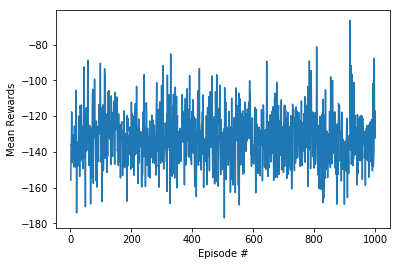

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(mean_rewards)+1), mean_rewards)
plt.ylabel('Mean Rewards')
plt.xlabel('Episode #')
plt.show()


In [13]:
# save your policy!
policy = torch.load('PPO.policy')

In [14]:
#policy_solution = torch.load('PPO_solution.policy')
env = gym.make('Pendulum-v0')
env.reset() 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.99723762,  0.07427738,  0.93735317])

In [15]:
play(env, policy, time=2000, nrand=5,n=1)